In [4]:
import pyabc
import parse
import numpy as np

In [2]:
header = r"""
"""

template = r"""
    \begin{{subfigure}}{{0.30\textwidth}}
        \centering
        \includegraphics[width=\textwidth]{{{{{kdeWMM}}}.pdf}}
        \caption{{}}
    \end{{subfigure}}
    \begin{{subfigure}}{{0.30\textwidth}}
        \centering
        \includegraphics[width=\textwidth]{{{{{kdeCBM}}}.pdf}}
        \caption{{}}
    \end{{subfigure}}
    \begin{{subfigure}}{{0.30\textwidth}}
        \centering
        \includegraphics[width=\textwidth]{{{{{mprob}}}.pdf}}
        \caption{{}}
    \end{{subfigure}}
"""

footer = r"""
"""

In [3]:
inference_files = sorted([
    "inference/inference_1.6000000000000014_0.8000000000000003_0.0_.db",
    "inference/inference_0.0_3.2_0.0_.db",
    "inference/inference_-4.8_3.2_0.0_.db",
], key=lambda s: -parse.parse("inference/inference_{diffusion:f}_{chi:f}_{k_d:f}_.db", s).named['diffusion'])

In [4]:
bounds = {
    "chi": (-2, 4),
    "diffusion": (-8, 4),
}

In [1]:
base_parameters = {
    'k_a': 0.002,
    'k_d': 0.1,
    'mu': 3.0,
    'kappa': 1.0,
    'gamma': 0.04,
    'diffusion': 0.6,
    'time_step': 0.1,
    'cell_radius': 6.0,
    'nucleus_radius': 2.5,
}

def log_value(p, name=None):
    return (np.log10(base_parameters[name]) if name else 0) + p * np.log10(2)

def exp_value(p, name=None):
    return (p - (np.log10(base_parameters[name]) if name else 0))/np.log10(2)

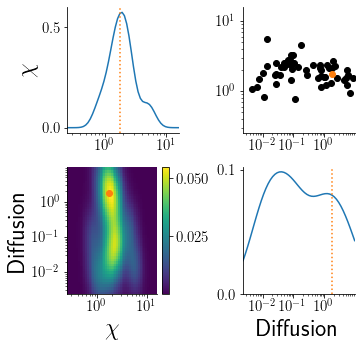

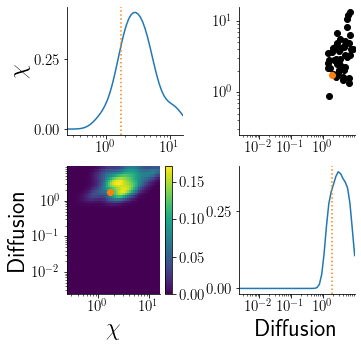

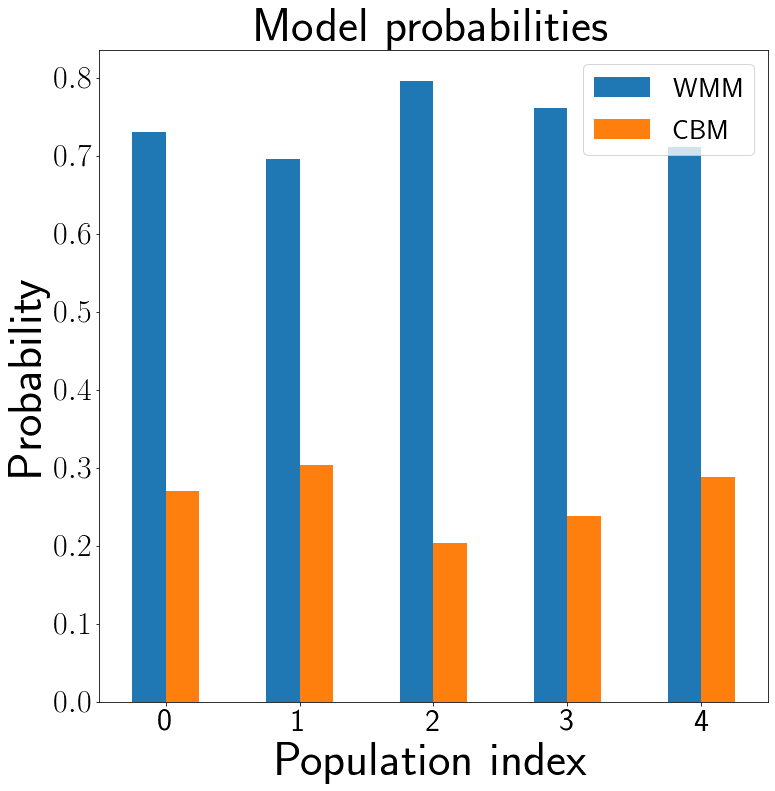

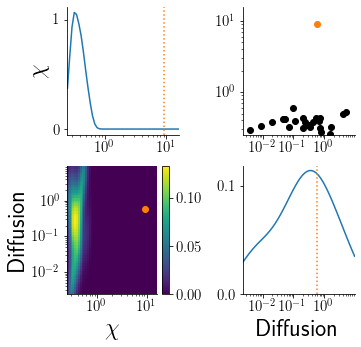

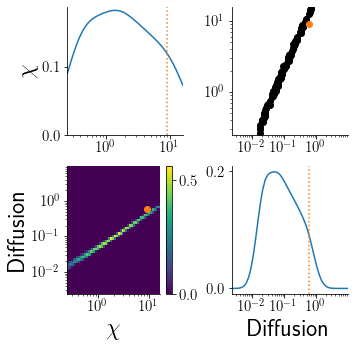

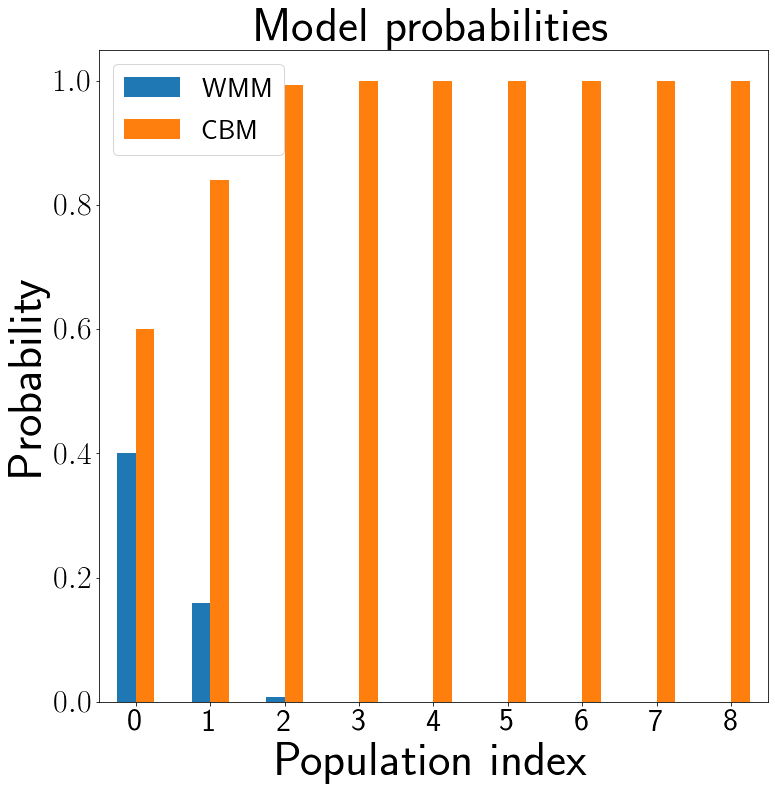

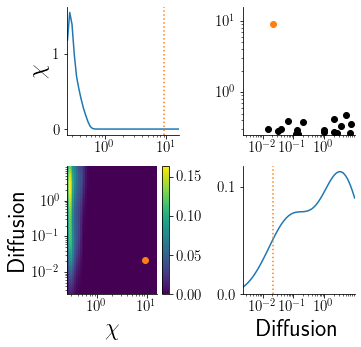

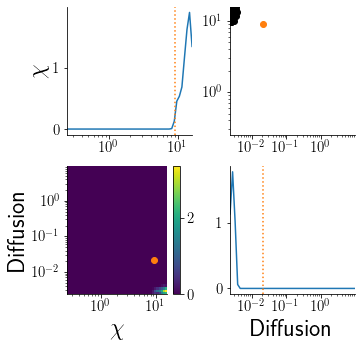

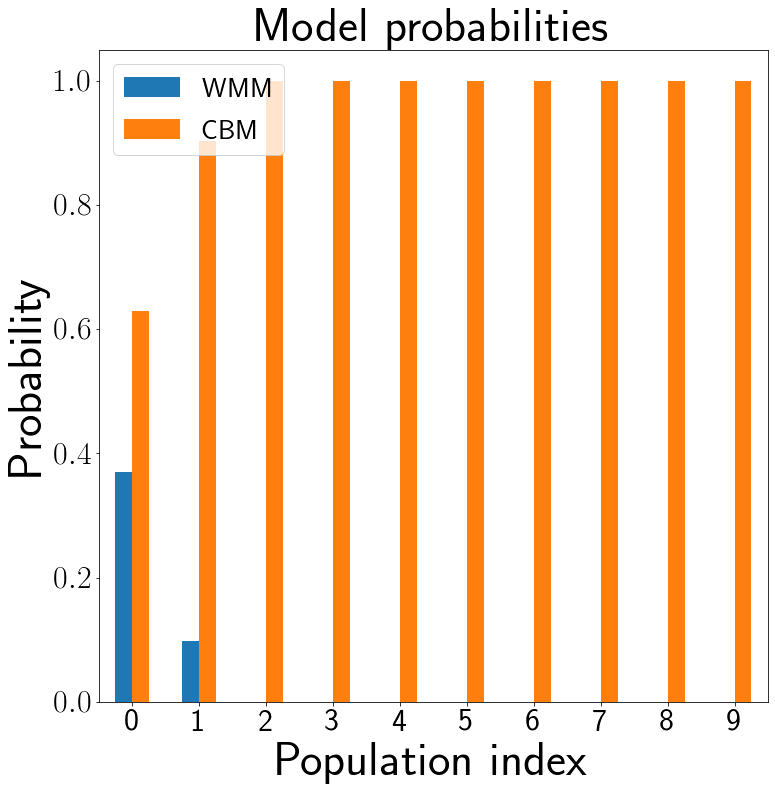

In [6]:
from pyabc.visualization import plot_kde_matrix_highlevel
import matplotlib.pyplot as plt
import matplotlib.ticker as mpt

tex = header

for inference_file in inference_files:
    params = {
          'figure.figsize': (12, 12),
          'legend.fontsize': 20,
          'axes.labelsize': 24,
          'axes.titlesize':24,
          'xtick.labelsize':15,
          'ytick.labelsize':15,
          'text.usetex':True,
         }

    plt.rcParams.update(params)
    
    db_path = "sqlite:///{}".format(inference_file)
    history = pyabc.History(db_path)

    true_parameters = parse.parse("inference/inference_{diffusion:f}_{chi:f}_{k_d:f}_.db", inference_file).named
    
    inference_file = ".".join(inference_file.split('/')[-1].split('.')[:-1])

    picturefiles = {}
    for model in range(2):
        t = 0
        try:
            while len(history.get_population(t=t).to_dict()[model]) > 10:
                t += 1
        except KeyError:
            pass
        t -= 1

        ax = plot_kde_matrix_highlevel(history, m=model, t=t,
                    limits=bounds,
                    refval=true_parameters
                )
        
        #TODO ax[0, 0].set_title(f"t={t}")

        for i, pi in enumerate(bounds.keys()):
            for j, pj in enumerate(bounds.keys()):
                xticks = list(range(
                    int(np.ceil(log_value(bounds[pi][0], name=pi if pi!='chi' else None))),
                    int(np.floor(log_value(bounds[pi][1], name=pi if pi!='chi' else None)))+1))
                ax[j, i].set_xticks([exp_value(p, name=pi if pi!='chi' else None) for p in xticks])
                ax[j, i].set_xticklabels([f'$10^{{{t}}}$' for t in xticks])
                ax[j, i].xaxis.set_minor_locator(mpt.FixedLocator(sum([[exp_value(np.log10(i*c), name=pi if pi!='chi' else None) for i in range(2,10)]
                                                                       for c in [0.001, 0.01, 0.1, 1, 10]],[])))

                if i != j:
                    yticks = list(range(
                        int(np.ceil(log_value(bounds[pj][0], name=pj if pj!='chi' else None))),
                        int(np.floor(log_value(bounds[pj][1], name=pj if pj!='chi' else None)))+1))
                    ax[j, i].set_yticks([exp_value(p, name=pj if pj!='chi' else None) for p in yticks])
                    ax[j, i].set_yticklabels([f'$10^{{{t}}}$' for t in yticks])
                    ax[j, i].yaxis.set_minor_locator(mpt.FixedLocator(sum([[exp_value(np.log10(i*c), name=pj if pj!='chi' else None) for i in range(2,10)]
                                                                           for c in [0.001, 0.01, 0.1, 1, 10]],[])))
                    
                if j == 0:
                    ax[i, j].set_ylabel("Diffusion" if pi == 'diffusion' else "$\chi$")
                if i == 1:
                    ax[i, j].set_xlabel("Diffusion" if pj == 'diffusion' else "$\chi$")

        picturefile = f"kde/kde_{inference_file}{'WMM' if not model else 'CBM'}"
        picturefiles["kdeWMM" if not model else "kdeCBM"] = "images/" + picturefile
        plt.savefig(picturefile + ".pdf")

        
    params = {
          'figure.figsize': (12, 12),
          'legend.fontsize': 28,
          'legend.title_fontsize': 28,
          'axes.labelsize': 48,
          'axes.titlesize':48,
          'xtick.labelsize':32,
          'ytick.labelsize':32,
          'text.usetex':True,
         }

    plt.rcParams.update(params)
    ax = pyabc.visualization.plot_model_probabilities(history)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, ['WMM', 'CBM'])
    
    picturefile = f"kde/{inference_file}mprob"
    picturefiles["mprob"] = "images/" + picturefile
    plt.savefig(picturefile + ".pdf")
    
    tex += template.format(**picturefiles)

tex += footer
with open("kde.tex", 'w') as f:
    f.write(tex)